In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import dill as pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import torch
import nibabel as nb

import nctpy

from tqdm.notebook import tqdm

In [2]:
DATA7_PATH = "/System/Volumes/Data/data/data7"
projects_path = f"{DATA7_PATH}/network_control/projects"
sys.path.insert(1, projects_path)
import CAP_tools


NC_path = f"{DATA7_PATH}/network_control/projects/network_control"
sys.path.insert(1, NC_path)
import plot
import surface_mapping as sfm
# from network_control import plot

# Parameters / Constants

In [5]:
N_PARCELS = 400

In [6]:
DTI_parcellation = f"Schaefer2018_{N_PARCELS}Parcels_17Networks_order_FSLMNI152_1mm"
fMRI_parcellation = DTI_parcellation.split("_order")[0]

subjects_list_file = f"{DATA7_PATH}/HCP_7T/scripts/_params/subject_list.txt"
parcellation_list_file = f"{DATA7_PATH}/HCP_7T/scripts/_params/parcellations.txt"
HCP_7T_DIR = f"{DATA7_PATH}/HCP_7T"
HCP_7T_fMRI_DIR = os.path.join(HCP_7T_DIR, "{subject}/MNINonLinear/Results/{data_type}")

pkl_cache_format = "cache/HCP_CAP_{filename}.pkl"

In [7]:
with open(subjects_list_file, 'r') as f:
    subject_list = sorted(f.read().split())

with open(parcellation_list_file, "r") as file:
    parcellation_path_dict = dict(line.strip().split(": ") for line in file.readlines())

fMRI_parcellation_path = parcellation_path_dict[fMRI_parcellation]
avoid_subjects = ["585256", #tfMRI movie2 PA missing, all rest intact
                  "102311", # DTI import failed, unclear if missing or what
]
subject_list = [s for s in subject_list if not s in avoid_subjects]

# Load ptseries 

In [8]:
def load_HCP_7T_nii(subject, data_type, file_type, fMRI_parcellation="", 
                    data_ext="_hp2000_clean_nilearn_ISCH"):
    """ """
    fMRI_parcellation = "_" + fMRI_parcellation if fMRI_parcellation != "" else ""
    subject_fmri_dir = HCP_7T_fMRI_DIR.format(subject=subject, data_type=data_type)
    pt_series_name = f"{data_type}_Atlas{data_ext}{fMRI_parcellation}.{file_type}.nii"
    subject_ptseries = os.path.join(subject_fmri_dir, pt_series_name)
    return nb.load(subject_ptseries)

In [9]:
data_types = ["rfMRI_REST1_7T_PA", "tfMRI_MOVIE_7T_DAY_1"]
data_exts = ["_hp2000_clean_nilearn", "_hp2000_clean_nilearn_ISCH"]

In [10]:
tf_arrays = {}
tf_arrays["rfMRI_all"] = []
tf_arrays["tfMRI_all"] = []

for subject in tqdm(subject_list, desc=f"Loading ptseries"):
    subj_data = {}
    for data_type, data_ext in zip(data_types, data_exts):
        
        cifti = load_HCP_7T_nii(subject, data_type, "ptseries",
                                fMRI_parcellation=fMRI_parcellation, data_ext=data_ext)
        subj_data[data_type] = np.array(cifti.get_fdata())

    rf_array = np.vstack([subj_data[dt] for dt in data_types if "rfMRI" in dt])
    tf_array = np.vstack([subj_data[dt] for dt in data_types if "tfMRI" in dt])
    tf_arrays["rfMRI_all"].append(rf_array)
    tf_arrays["tfMRI_all"].append(tf_array)

tf_arrays["rfMRI_all"] = np.array(tf_arrays["rfMRI_all"])
tf_arrays["tfMRI_all"] = np.array(tf_arrays["tfMRI_all"])
template_cifti = cifti

rfMRI_all = tf_arrays["rfMRI_all"]
tfMRI_all = tf_arrays["tfMRI_all"]
rfMRI_all.shape, tfMRI_all.shape

Loading ptseries:   0%|          | 0/174 [00:00<?, ?it/s]

((174, 900, 400), (174, 1432, 400))

In [11]:
ROI_labels = [label for label, _, index in template_cifti.header.get_axis(1)]
clean_ROI_labels = [l.split("works_")[1] for l in ROI_labels]
network_labels = [l.split("_", maxsplit=3)[2] for l in ROI_labels]

network_label_order = []
_ = [network_label_order.append(net) for net in network_labels if net not in network_label_order]

# Load CAP States

In [12]:
HCP_CAP_state_results_dir = f"{DATA7_PATH}/network_control/results/HCP_7T_analysis/CAP_states"

CAP_analysis_label = "tfMRI_MOVIE_7T_DAY_1"
isc = 0

isc_tag = f"_ISC_{isc * 100:0.0f}" if isc > 0 else ""
K = 12

CAP_analysis_path = f"{HCP_CAP_state_results_dir}/{CAP_analysis_label}{isc_tag}"
CAP_pkl_path = f"{CAP_analysis_path}/{CAP_analysis_label}_CAP_states_K{K}.pkl"

In [13]:
with open(CAP_pkl_path, 'rb') as file:
    CAP_states, CAP_labels, CAP_isc_df, CAP_ROI_labels, CAP_ptseries_paths = pickle.load(file)
    CAP_states = np.array(CAP_states)
    CAP_subjects = [path.split("HCP_7T/")[1].split("/MNI")[0] for path in CAP_ptseries_paths]
    CAP_labels = CAP_labels.reshape(len(CAP_subjects), -1)

assert all(subj in CAP_subjects for subj in subject_list)
assert CAP_labels.shape[1] == tfMRI_all.shape[1]
CAP_labels = CAP_labels[np.isin(CAP_subjects, subject_list)]
assert tfMRI_all.shape[:2] == CAP_labels.shape

# State Correlation between Subjects

In [15]:
ntfMRI_all =  (tfMRI_all / np.sum(tfMRI_all ** 2, axis=2, keepdims=True))

MA = np.array([[np.sqrt(np.sum((ntfMRI_all[i] - ntfMRI_all[j]) ** 2, axis=1))
                for i in range(174)] for j in range(174)])

MA_mean = np.clip(MA.mean(axis=2) - .13, 0, 0.045)
M = np.abs(np.corrcoef(ntfMRI_all.reshape(174, -1)))
M = (M + M.T) / 2
M[np.diag_indices_from(M)] = 1

M = np.array([[(CAP_labels[i] == CAP_labels[j]).mean() for i in range(174)] for j in range(174)])

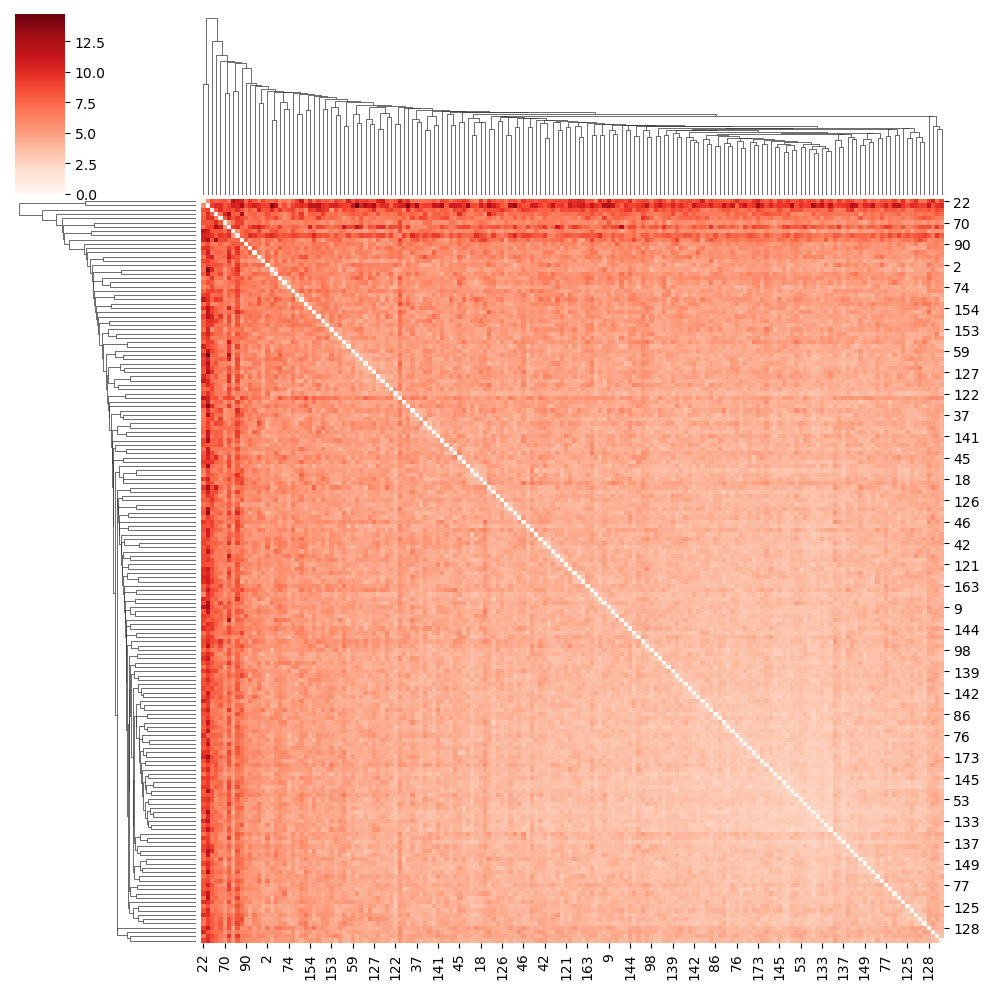

In [16]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

DF_dism = 1 / np.clip(M, 0.04, 1) - 1
# DF_dism = MA_mean

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=plt.cm.Reds)

# Bold Velocity Points

In [19]:
def znorm(x, axis=None):
    return (x - np.mean(x, axis=axis, keepdims=True)) / np.std(x, axis=axis, keepdims=True)

(-3.0, 5.0)

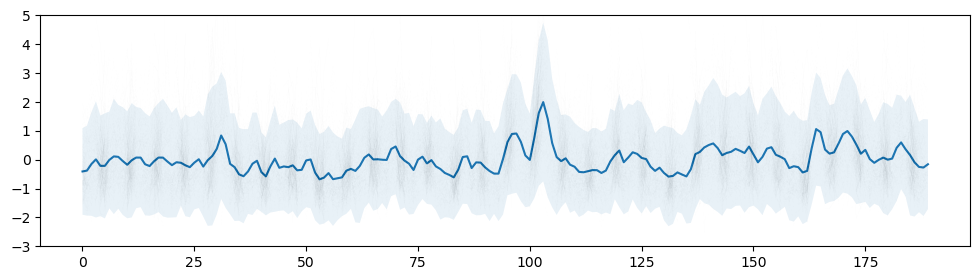

In [20]:
BOLD_velocity = np.sqrt(np.sum(np.gradient(tfMRI_all, axis=1) ** 2, axis=2))
BOLD_accel = np.sqrt(np.sum(np.gradient(np.gradient(tfMRI_all, axis=1), axis=1) ** 2, axis=2))
n_sm = 1
BV_sm = np.array([np.convolve(bv, np.ones(n_sm)/n_sm, mode = "valid") for bv in BOLD_velocity])
BV_sm = znorm(BV_sm, axis=1)

n_crop = 10
clip_change_inds = np.where(np.mean(BV_sm, axis=0) > 1)[0]
clip_change_inds = np.hstack([np.arange(max(ci - n_crop, 0), min(ci + n_crop, len(BV_sm[0])))
                                       for ci in clip_change_inds])
clip_change_inds = np.sort(np.unique(clip_change_inds))
clip_change_inds = np.hstack([np.arange(10), np.arange(200, len(BV_sm[0]))])
crop_inds = np.isin(np.arange(len(BV_sm[0])), clip_change_inds)


BV_sm = BV_sm[:, ~crop_inds]
BV_sm = znorm(BV_sm, axis=1)

trs = np.arange(len(BV_sm[0]))
fig, ax = plt.subplots(figsize=(12, 3))
m = np.mean(BV_sm, axis=0)
s = np.std(BV_sm, axis=0)
ax.plot(m)
ax.plot(trs, BV_sm.T, linewidth=0.001, color="k");
ax.fill_between(trs, m - 1.96 * s, m + 1.96 * s, alpha=0.1)
ax.set_ylim(-3, 5)

<Axes: ylabel='Density'>

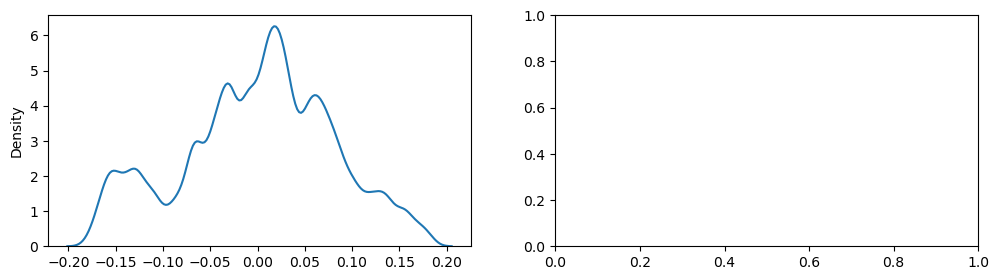

In [24]:
r_s = []
for i in range(400):
    # for j in range(len(BV_sm)):
    #     r, p = scipy.stats.pearsonr(BV_sm[j], tfMRI_all[j, ~crop_inds, i])
    #     r_s.append(r)
    r, p = scipy.stats.pearsonr(BV_sm.ravel(), tfMRI_all[:, ~crop_inds, i].ravel())
    # r, p = scipy.stats.pearsonr(m.ravel(), np.mean(tfMRI_all[:, ~crop_inds, i], axis=0).ravel())
    r_s.append(r)

fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 3))
sns.kdeplot(r_s, bw_method=0.1, ax=a0)